# Koelsch ROIs - Create Spheres based on the coordinates
Paper: A coordinate-based meta-analysis of music-evoked emotions
DOI: 10.1016/j.neuroimage.2020.117350

In [ ]:
# %% Import libraries
import os

import pandas as pd
import nibabel as nib
import numpy as np
import templateflow.api as tflow


In [ ]:
t1w_img_path = tflow.get("MNI152NLin2009cAsym", desc="brain", resolution=2, suffix="T1w", extension="nii.gz")

t1w_img = nib.load(t1w_img_path)
AFF = t1w_img.affine

In [72]:
# %% Load the coordinates in MNI - these have been created by TAL2MNI (https://bioimagesuiteweb.github.io/webapp/mni2tal.html)
# X,Y,Z coordinates are in MNI space
coords = pd.read_csv("clusters_peak_MNI.csv")

# %% Convert the coordinates to voxel space using the affine matrix (AFF)

# Create a new column for the voxel coordinates
coords["voxelX"] = np.nan
coords["voxelY"] = np.nan
coords["voxelZ"] = np.nan

# Loop through the rows and convert the MNI coordinates to voxel coordinates
for i in range(coords.shape[0]):
    x, y, z, _ = np.dot(np.linalg.inv(AFF), np.append(coords.loc[i, ["mniX", "mniY", "mniZ"]].values, 1))
    coords.loc[i, "voxelX"] = np.round(x)
    coords.loc[i, "voxelY"] = np.round(y)
    coords.loc[i, "voxelZ"] = np.round(z)

coords

,Label,mniX,mniY,mniZ,voxelX,voxelY,voxelZ
0,R_anterior_hippocampus,25,-12,-17,61.0,60.0,31.0
1,R_amygdala,21,-2,-16,59.0,65.0,31.0
2,R_nac,9,11,-6,53.0,72.0,36.0
3,R_caudate,9,7,4,53.0,70.0,41.0
4,L_nac,-12,13,-8,42.0,73.0,35.0
5,L_caudate,-8,9,3,44.0,71.0,41.0
6,L_auditory1,-53,-4,-1,22.0,64.0,39.0
7,L_auditory2,-51,-15,1,23.0,59.0,40.0
8,L_par_operculum,-44,-28,10,26.0,52.0,44.0
9,R_auditory1,51,-15,2,74.0,59.0,40.0


In [75]:
# %% Iterate through the coordinates and create a sphere around each coordinate
n_clusters = coords.shape[0]
for i in range(n_clusters):
    x = coords.loc[i, "voxelX"]
    y = coords.loc[i, "voxelY"]
    z = coords.loc[i, "voxelZ"]
    name = coords.loc[i, "Label"]

    os.system(f"fslmaths {t1w_img_path} -mul 0 -add 1 -roi {x} 1 {y} 1 {z} 1 0 1 spheres/{name}_roi.nii.gz -odt float")

    os.system(f"fslmaths spheres/{name}_roi.nii.gz -kernel sphere 4 -fmean spheres/{name}_roi.nii.gz -odt float")

    os.system(f"fslmaths spheres/{name}_roi.nii.gz -bin spheres/{name}_roi.nii.gz ")


In [76]:
# create spheres path list
spheres_list = []
for ii in range(n_clusters):
    spheres_list.append(f"spheres/{coords.iloc[ii, 0]}_roi.nii.gz")
spheres_list

['spheres/R_anterior_hippocampus_roi.nii.gz',
 'spheres/R_amygdala_roi.nii.gz',
 'spheres/R_nac_roi.nii.gz',
 'spheres/R_caudate_roi.nii.gz',
 'spheres/L_nac_roi.nii.gz',
 'spheres/L_caudate_roi.nii.gz',
 'spheres/L_auditory1_roi.nii.gz',
 'spheres/L_auditory2_roi.nii.gz',
 'spheres/L_par_operculum_roi.nii.gz',
 'spheres/R_auditory1_roi.nii.gz',
 'spheres/R_auditory2_roi.nii.gz',
 'spheres/L_amygdala_roi.nii.gz',
 'spheres/L_anterior_hippocampus_roi.nii.gz',
 'spheres/L_hippocampal_form_roi.nii.gz',
 'spheres/L_acc_roi.nii.gz',
 'spheres/L_s32_roi.nii.gz',
 'spheres/L_pcc_roi.nii.gz',
 'spheres/L_mcc_roi.nii.gz',
 'spheres/R_fp2_roi.nii.gz',
 'spheres/R_p24_roi.nii.gz',
 'spheres/R_p32_roi.nii.gz',
 'spheres/R_inf_colliculus_roi.nii.gz',
 'spheres/R_medial_geniculate_roi.nii.gz']

In [ ]:
# Load base image to get shape and affine
ref_img = nib.load(t1w_img_path)
atlas_data = np.zeros(ref_img.shape, dtype=np.int16)

for i in range(n_clusters):
    name = coords.loc[i, "Label"]
    sphere_path = f"spheres/{name}_roi.nii.gz"
    sphere_img = nib.load(sphere_path)
    sphere_data = sphere_img.get_fdata()

    # Overwrite logic: assign label i+1 where sphere is 1
    atlas_data[sphere_data > 0] = i + 1

# Save the final atlas
atlas_img = nib.Nifti1Image(atlas_data, affine=ref_img.affine)
nib.save(atlas_img, "spheres/koelsch_spheres_atlas.nii.gz")


In [65]:
# export region names as txt file
region_names = coords.iloc[:, 0]
region_names.to_csv("spheres/koelsch_spheres_atlas.txt", index=False, header=False)

/opt/anaconda3/envs/brainplayback_task02/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



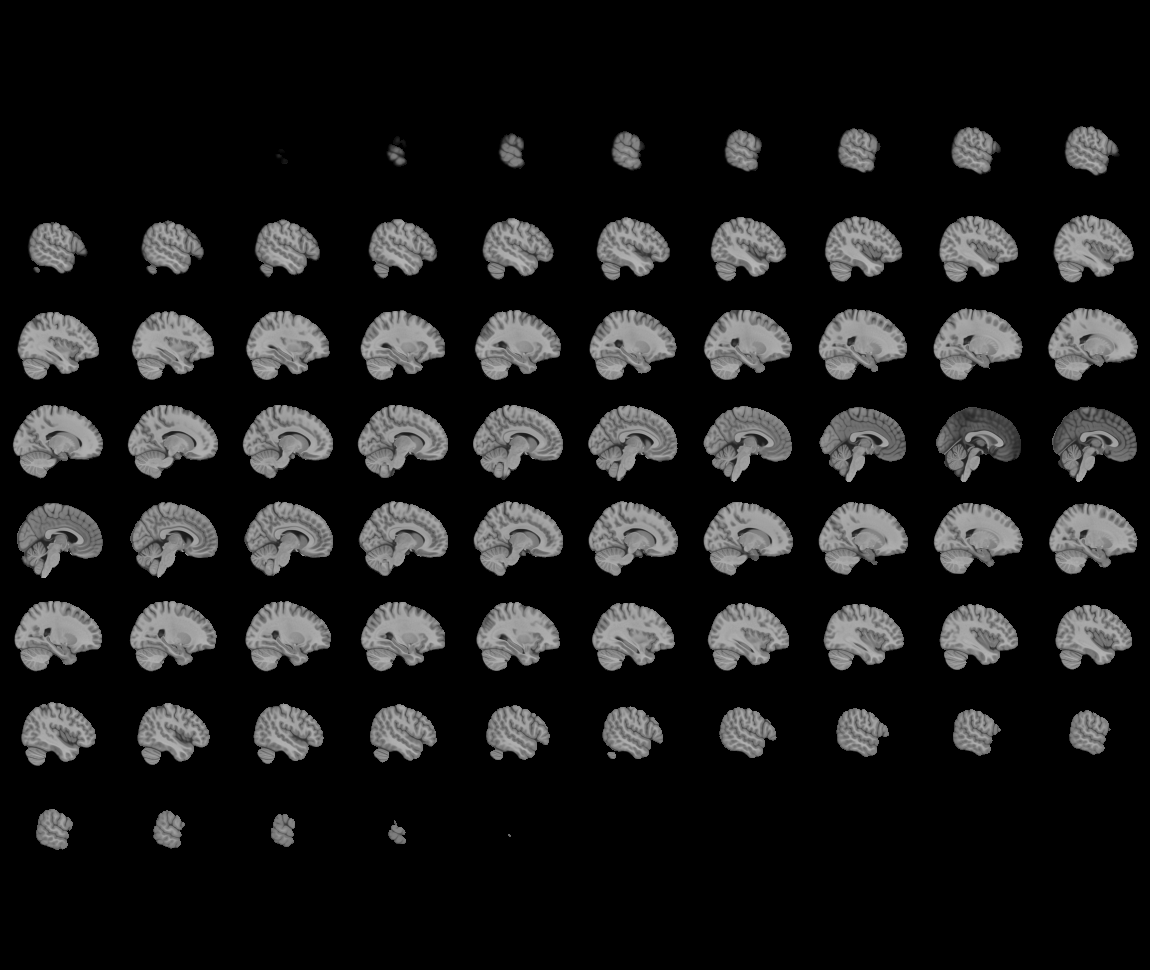
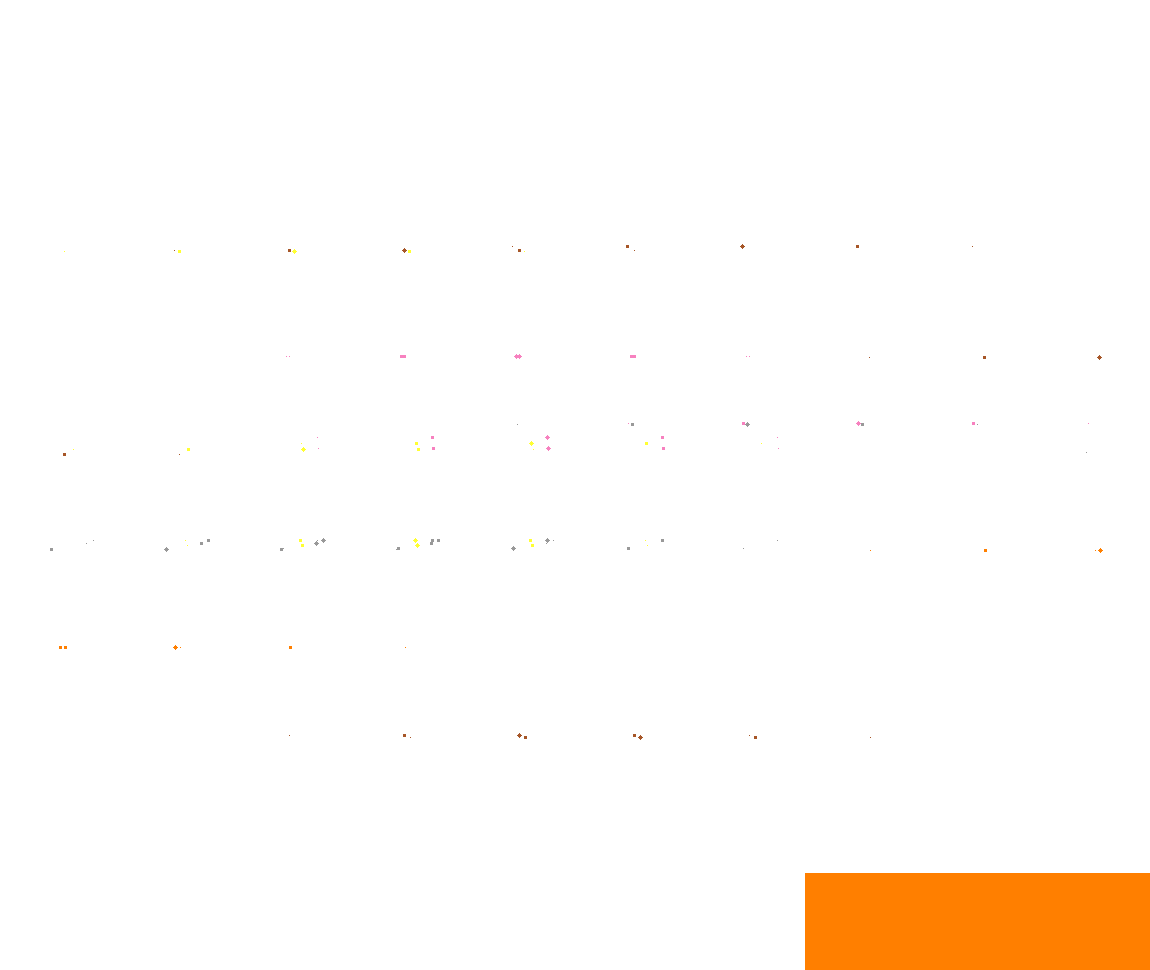

In [81]:
from nilearn.plotting import view_img

view_img("spheres/koelsch_spheres_atlas.nii.gz", bg_img=t1w_img_path, cmap="Set1", title="Koelsch spheres atlas")